In [1]:
import os

import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
import json

DATA_DIR = "../data"

# Set tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# run_id = "42c00ef221ef48538e51edbfb8ffc984"

# model = mlflow.sklearn.load_model(f"runs:/{run_id}/early_diagnosis")

logged_model = 'runs:/b4ae779d02b34ff692c21ad02b667445/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.sklearn.load_model(logged_model)


C:\Users\flis1\AppData\Local\miniconda3\envs\stratifyHF\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded_model.named_steps

{'preprocessor': ColumnTransformer(transformers=[('both', MissingIndicator(features='all'),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027F450B9310>),
                                 ('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027F463D94C0>),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot',
                                                   OneHotEncoder(drop='if_binary',
                                                 

In [22]:
feature_names = loaded_model["preprocessor"].get_feature_names_out()

In [23]:
feature_importance = (
    pd.Series(loaded_model["classifier"].feature_importances_, index=feature_names).sort_values(ascending=False)
)
feature_importance.to_csv(os.path.join(DATA_DIR, "stats", "gini_feature_importance.csv")) 

In [6]:
import os

balanced_df = (
    pd.read_csv(os.path.join(DATA_DIR, "processed", "balanced_ED_NT.csv"))
      .set_index(["ID", "date"])
      .rename(columns={'Med_LD_permanent':"Med_LD"})
)
df = pd.read_csv(os.path.join(DATA_DIR, "processed", "early_diagnosis_NT.csv"))
hfpef_df = (
    pd.read_csv(os.path.join(DATA_DIR, "raw", "hfpef_confirmed_HF.csv"))
      .rename(columns={"patid": "ID"})
)
hfref_df = (
    pd.read_csv(os.path.join(DATA_DIR, "raw", "hfref_confirmed_HF.csv"))
      .rename(columns={"patid": "ID"})
)

hfpef_ed_df = (pd.merge(df, hfpef_df, on="ID").set_index(["ID", "date"])
                 .rename(columns={'Med_LD_permanent':"Med_LD"}))
hfref_ed_df = (pd.merge(df, hfref_df, on="ID").set_index(["ID", "date"])
                 .rename(columns={'Med_LD_permanent':"Med_LD"}))
df = df.set_index(["ID", "date"]).rename(columns={'Med_LD_permanent':"Med_LD"})

In [7]:
(
    (balanced_df.rename(columns={"Med_LD_permanent": "Med_LD"}).loc[:, loaded_model.feature_names_in_].count()/len(balanced_df))
    .sort_values(ascending=False).mul(100).round(2)
        .to_csv(os.path.join(DATA_DIR, "stats", "ED_cprd_completeness.csv"))
)

In [11]:
imputer = loaded_model['preprocessor']

test_examples_df = balanced_df.iloc[np.random.randint(0, len(balanced_df), 100)]

imputed_test_examples_df = pd.DataFrame(imputer.transform(test_examples_df), columns=imputer.get_feature_names_out(), index=test_examples_df.index)

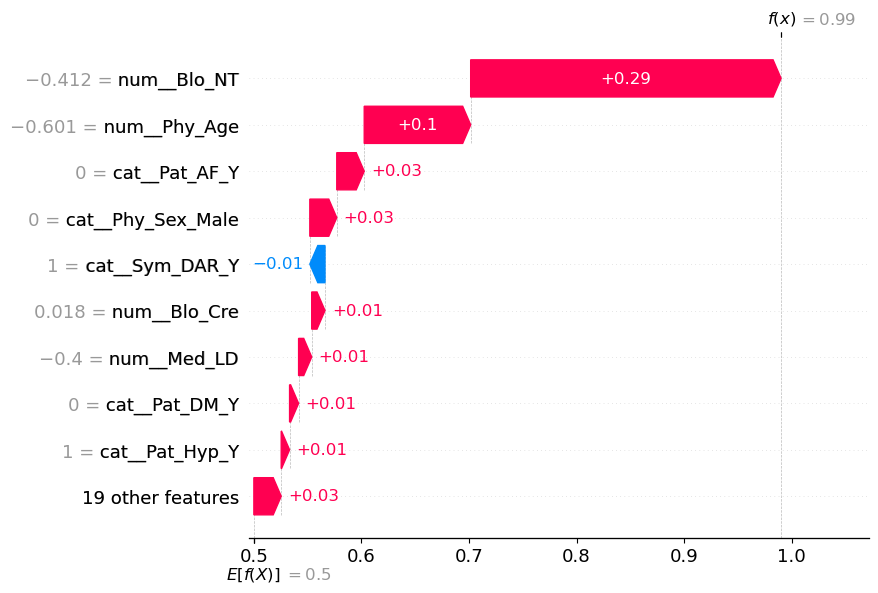

In [13]:
import shap

explainer = shap.TreeExplainer(loaded_model["classifier"])

shap_values = explainer(imputed_test_examples_df)


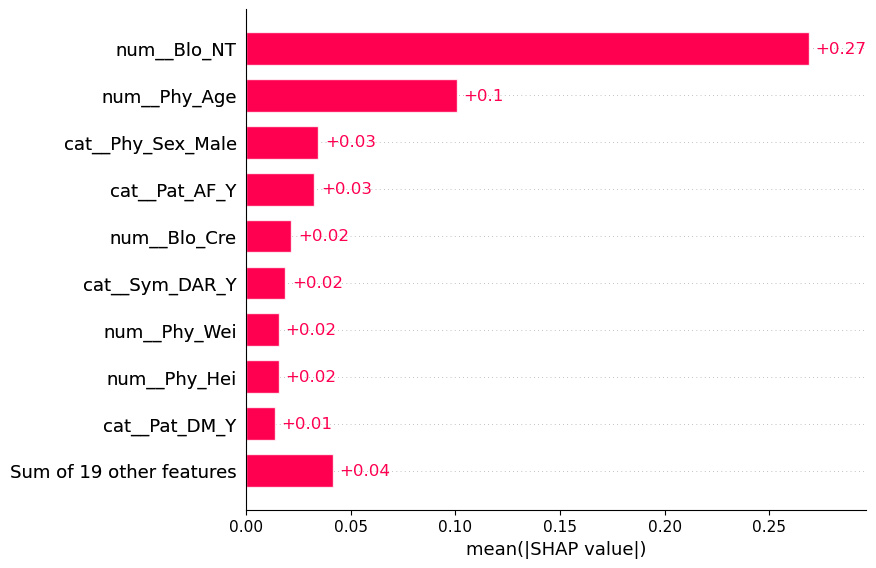

In [18]:
shap.plots.bar(shap_values[:, :, 1])

In [36]:
shap_summary = np.mean(np.abs(shap_values.values), axis=(0, 1))

In [42]:
shap_importances = pd.Series(np.mean(np.abs(shap_values.values[:, :, 1]), axis=0), index=feature_names)

In [46]:
shap_importances.sort_values(ascending=False).to_csv(os.path.join(DATA_DIR, "stats", "shap_feature_importance.csv"))